This notebook introduces the [DynaPicker](https://doi.org/10.48550/arXiv.2211.09539) model. It explains how to load the pretrained model and apply it to generate discrete picks, and how to retrain the model.

In [1]:
import os
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import torch
from saipy.utils.picktools import *
from saipy.utils.visualizations import *
from saipy.models.dynapicker import *
import h5py

/home/seismoai/data/chakraborty/DeepSeis_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### $(1)$ Loading pre-trained model

In [2]:
%load_ext autoreload
%autoreload 2
model_path = ''
model = load_model(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

Device:  cpu


### $(2)$ Phase-picking using pre-trained model

plotting parameters 

In [3]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
font_size = 14
params = {
    'legend.fontsize': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size
}
plt.rcParams.update(params)

### $(\mathrm{ii})$ An example using STEAD dataset

In [4]:
%load_ext autoreload
%autoreload 2
from saipy.data.base import STEAD
stead = STEAD('/home/seismoai/data')
metadata,waveform = stead.get_dynapicker_data()

torch.cuda.empty_cache()

# trace selection
df = metadata[(metadata.trace_category == 'earthquake_local')]
ev_list = df['trace_name'].to_list()[10:11]

evi = ev_list[0]
dataset = waveform.get('data/'+str(evi)) 
# hdf5 dataset into obspy.stream
stream = make_stream_stead(dataset) 
prob_p,prob_s, pwave, swave = phase_picking(device, model, stream, bandpass_filter_flag=True, picker_num_shift=10,
                                            batch_size=4, fremin=1, fremax=40, fo=5, fs=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/seismoai/data/chakraborty/DeepSeis_venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


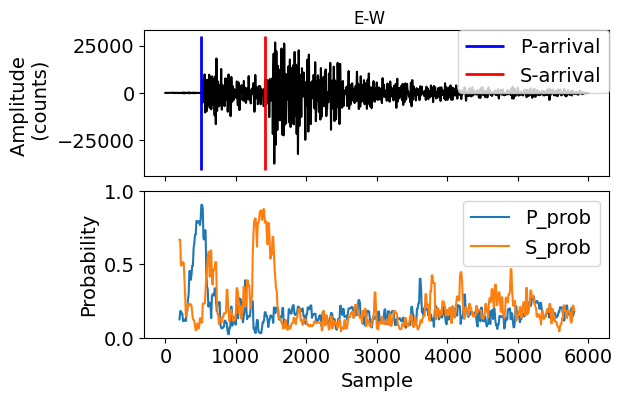

In [5]:
%load_ext autoreload
%autoreload 2
fig = plot_dynapicker_stead(stream, dataset, prob_p, prob_s, picker_num_shift=10, figure_size=(6,4), index=0)
# using fig.savefig('..') to save the figure

### $(\mathrm{iii})$ An example using INSTANCE dataset

In [6]:
%load_ext autoreload
%autoreload 2
from saipy.data.base import INSTANCE
instance = INSTANCE('/home/seismoai/data')
instance_metadata, instance_waveform = instance.get_dynapicker_data(event_type='EQ')

torch.cuda.empty_cache()

wftype='ev_c'
line = 1000
df = instance_metadata
h5 = instance_waveform
stream, row = make_stream_instance(df, h5, line, wftype)
prob_p, prob_s, pwave, swave = phase_picking(device, model, stream, bandpass_filter_flag=True, 
                                             picker_num_shift=10, batch_size=4, fremin=1, fremax=40, 
                                             fo=5, fs=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


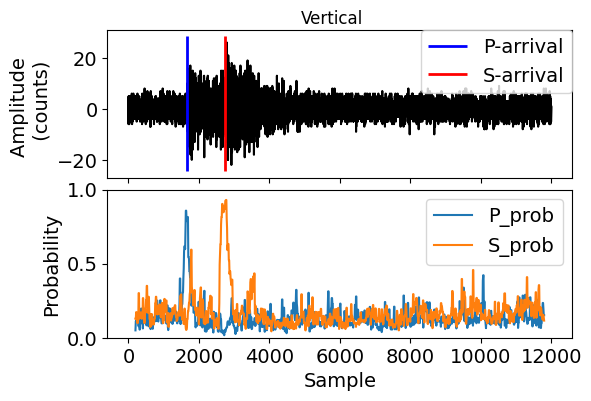

In [7]:
%load_ext autoreload
%autoreload 2
fig = plot_dynapicker_instance(stream, row, prob_p, prob_s, picker_num_shift=10, index=2, figure_size=(6,4))

### $(\mathrm{iv})$ Real-time data picking 

dowdloading waveform

In [8]:
from saipy.data.realdata import *
wsp = "INGV"
network = "MN"
station = "AQU"
location = "*"
channel = "HH?"
t = UTCDateTime(2009, 4, 6, 1, 30)
stream = waveform_download(wsp=wsp, net=network, sta=station, loc=location, chan=channel, starttime=t, endtime=t+20)

phase picking

In [9]:
bandpass_filter =  True
prob_p, prob_s, pwave, swave = phase_picking(device, model, stream, bandpass_filter_flag=True, picker_num_shift=10, batch_size=4, fremin=1, fremax=40, fo=5, fs=100)

visualization 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


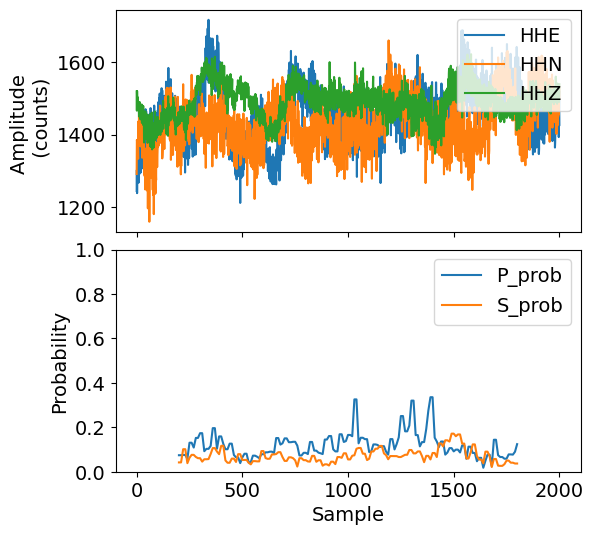

In [10]:
%load_ext autoreload
%autoreload 2
fig = plot_dynapicker_stream(stream, prob_p, prob_s, picker_num_shift=10, figure_size=(6,6))

### $(3)$ Dynapicker retraining
The following code-blocks show how to retrain dynapciker on invidual 4s-window-format data

### $(\mathrm{i})$ Setting up

In [11]:
%load_ext autoreload
%autoreload 2
from saipy.modules.phaseclassification import *
from saipy.models.dynapicker import *

seed = 24
set_seed(seed) # reproduce
# users can update default values using args.variable_name = new value
args = arguments() 
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
print(args)

Namespace(batch_size=3, epochs=20, lr=0.001, model_save_path='./saving_model', num_classes=3, patience=5, verbose=True)


### $(\mathrm{ii})$ Picker retraining

Here, random data is used.

In [ ]:
%load_ext autoreload
%autoreload 2


from sklearn.model_selection import train_test_split
num = 120
x = np.random.random_sample((num, 400, 3))
y = np.array([0,1,2]*(int(num/3)))

train_x, rest_x, train_y, rest_y = train_test_split(x, y, train_size=0.8, random_state=seed)
valid_x, test_x, valid_y, test_y = train_test_split(rest_x, rest_y, train_size=0.5, random_state=seed)

train_dataset = CustomDataset(train_x, train_y)
valid_dataset = CustomDataset(valid_x, valid_y)

#dataloder
Train_Loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)

Valid_Loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)
retrained_model, train_loss, valid_loss = train(args, device, Train_Loader, Valid_Loader, criterion, optimizer, scheduler=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/20 [00:00<?, ?it/s]

[ 1/20] train_loss: 309.079182 valid_loss: 302.527378
Validation loss decreased (inf --> 302.527378).  Saving model ...


  5%|▌         | 1/20 [01:28<28:09, 88.95s/it]

### $(\mathrm{iii})$ Visualizing the training and valid losses and the early stopping checkpoint

In [ ]:
%load_ext autoreload
%autoreload 2
fig= plot_dynapicker_train_history(train_loss, valid_loss, figure_size=(6,4))
fig.savefig('./saving_model/loss.png')

### $(\mathrm{v})$ Model testing

In [ ]:
%load_ext autoreload
%autoreload 2

test_dataset = CustomDataset(test_x, test_y)
Test_Loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=args.batch_size,  shuffle=False, num_workers=0)
preds, pred_prob = test(args, device, retrained_model, Test_Loader, criterion)

Confusion matrix plotting

In [ ]:
%load_ext autoreload

%autoreload 2
class_labels = ['P-phase', 'S-phase', 'Noise']
fig, metrics_report = plot_dynapicker_confusionmatrix(y_true=test_y, y_pred=preds, label_list=class_labels, digits_num=6, figure_size=(6,4), cmap=plt.cm.Greens)
fig.savefig('./saving_model/cm.png')

metrics report

In [ ]:
print("Metrics report \n", metrics_report )

Precision_recall curve plotting

In [ ]:
%load_ext autoreload
%autoreload 2
fig = plot_precision_recall_curve(y_true=test_y, y_pred=preds, y_pred_prob=pred_prob, label_list=class_labels, figure_size=(6,4));
## please use fig.savefig() to save the figure in the desired format

ROC curve poltting for multiple classes

In [ ]:
%load_ext autoreload

%autoreload 2
fig = plot_roc_curve(y_true=test_y, y_pred=preds, y_pred_prob=pred_prob, label_list=class_labels, figure_size=(6,5));
fig.savefig('./saving_model/roc_curve.png')